# Data Preparation

In [3]:
import os
import json
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pymysql
import urllib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import skew, kurtosis, probplot

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from arch import arch_model

In [4]:
# 1) load your creds
load_dotenv()
user     = os.getenv("MYSQL_USER")
raw_pw   = os.getenv("MYSQL_PASSWORD")
password = urllib.parse.quote_plus(raw_pw)
host     = os.getenv("MYSQL_HOST")
port     = os.getenv("MYSQL_PORT")
db       = os.getenv("MYSQL_DATABASE")

# 2) build the engine
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{db}")

In [5]:
df_tf = pd.read_sql_query(
    "SELECT DISTINCT timeframe FROM ohlcv ORDER BY timeframe;",
    con=engine
)
timeframes = df_tf['timeframe'].tolist()

def tf_to_minutes(tf):
    unit_minutes = {
        'm':1,
        'h':60,
        'd':60*24,
        'w':60*24*7
    }
    value, unit = int(tf[:-1]), tf[-1]
    return value*unit_minutes[unit]

# Sort timeframe in ascending order
timeframes = sorted(timeframes, key=tf_to_minutes)
timeframes

['1m', '3m', '5m', '15m', '30m', '1h', '4h', '6h', '12h', '1d', '1w']

## Example

In [6]:
query = f"""
SELECT datetime, open, high, low, close, volume
FROM ohlcv
WHERE timeframe = '1h'
ORDER BY timestamp
"""
df = pd.read_sql_query(query, con=engine)
df.set_index('datetime', inplace=True)
print(df.dtypes)

open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object


In [7]:
df.describe()

,open,high,low,close,volume
count,33269.000000,33269.000000,33269.000000,33269.000000,33269.000000
mean,46099.112352,46280.557445,45912.874663,46100.741666,412.640789
std,23273.847460,23367.389997,23178.491771,23274.856717,554.555765
min,15656.540000,15770.000000,15484.340000,15656.540000,0.029893
25%,26921.960000,26990.000000,26870.360000,26921.960000,76.982611
50%,41767.690000,41931.530000,41616.820000,41770.000000,214.790199
75%,62459.770000,62721.740000,62161.080000,62459.920000,559.853216
max,108322.460000,109900.000000,107794.040000,108322.460000,15206.868300


# 1. Data Validation

Tests: 
1. Datetime Integrity & Missing Intervals
- week timeframe had 198 missing week time -> drop data with week timeframe
2. Basic Value Sanity Checks between :
- no major issues
3. Cross-Field Consistency (aggregation test for adjacent timeframes)
- Upscaled 1m data to timeframe 1h and 4h by creating OHLCV data.
- no major issues: every values were within 1%
- when i set accuracy constraint as within 0.1%, there are differences particularly in volume data

In [8]:
ohlcv = {}
for tf in timeframes:
    query = f"""
    SELECT datetime, open, high, low, close, volume
    FROM ohlcv
    WHERE timeframe = '{tf}'
    ORDER BY timestamp
    """
    df = pd.read_sql_query(query, con=engine)
    df.set_index('datetime', inplace=True)
    ohlcv[tf] = df

# Container for anomaly reports
report = {}

# Define frequency mapping
freq_map = {
    '1m': 'min',
    '3m': '3min',
    '5m': '5min',
    '15m': '15min',
    '30m': '30min',
    '1h': 'h',
    '4h': '4h',
    '12h': '12h',
    '1d': 'D',
    '1w': 'W',
}

# 1) Timestamp Integrity & Missing Intervals
timestamps_diff = {}
for tf, df_ohlcv in ohlcv.items():
    idx = df_ohlcv.index
    # Monotonicity & uniqueness
    report[f"{tf}_monotonic"] = idx.is_monotonic_increasing
    report[f"{tf}_unique"] = idx.is_unique

    # Otherwise build the expected full range
    full_range = pd.date_range(start=idx.min(), end=idx.max(), freq=tf)
    missing = full_range.difference(idx)

    report[f"{tf}_missing_count"] = len(missing)
    report[f"{tf}_missing_samples_head"] = missing.astype(str).tolist()

# 2) Basic Value Sanity Checks
for tf, df_ohlcv in ohlcv.items():
    cond_price = (df_ohlcv['high'] >= df_ohlcv[['open','close','low']].max(axis=1)) & \
                 (df_ohlcv['low']  <= df_ohlcv[['open','close','high']].min(axis=1))
    cond_volume = df_ohlcv['volume'] >= 0
    cond_positive = (df_ohlcv[['open','high','low','close']] > 0).all(axis=1)
    invalid = df_ohlcv.index[~(cond_price & cond_volume & cond_positive)]
    report[f"{tf}_value_violations"] = len(invalid)
    report[f"{tf}_value_violation_samples"] = invalid.astype(str).tolist()

# 3) Cross-Field Consistency (aggregation test for adjacent timeframes)
pairs = [('1m','1h'), ('1m','4h')]
for low_tf, high_tf in pairs:
    df_low  = ohlcv[low_tf].copy()
    df_high = ohlcv[high_tf]

    # resample the lower timeframe to the higher timeframe
    agg = df_low.resample(freq_map[high_tf]).agg({
        'open':   'first',
        'high':   'max',
        'low':    'min',
        'close':  'last',
        'volume': 'sum'
    })

    # Compare to the “official” higher timeframe
    common_idx = df_high.index.intersection(agg.index)
    mismatches = {}
    for col in ['open','high','low','close','volume']:
        diff = (agg.loc[common_idx, col] - df_high.loc[common_idx, col])/df_high.loc[common_idx, col] > 1e-2
        mismatches[col] = int(diff.sum())
        mismatches_samples = agg[diff] - df_high[diff]
       
    report[f"{low_tf}_to_{high_tf}_mismatches"] = mismatches

# 7) Save anomaly report to JSON
with open('validation_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print("Data validation complete. See validation_report.json for details.")




/var/folders/3y/9m0_h3_50mbgtyzs2dx_pmc80000gn/T/ipykernel_14739/2015533513.py:39: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  full_range = pd.date_range(start=idx.min(), end=idx.max(), freq=tf)
/var/folders/3y/9m0_h3_50mbgtyzs2dx_pmc80000gn/T/ipykernel_14739/2015533513.py:39: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  full_range = pd.date_range(start=idx.min(), end=idx.max(), freq=tf)
/var/folders/3y/9m0_h3_50mbgtyzs2dx_pmc80000gn/T/ipykernel_14739/2015533513.py:39: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  full_range = pd.date_range(start=idx.min(), end=idx.max(), freq=tf)
/var/folders/3y/9m0_h3_50mbgtyzs2dx_pmc80000gn/T/ipykernel_14739/2015533513.py:39: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  full_range = pd.date_range(start=idx.min(), end=idx.max(), f

Data validation complete. See validation_report.json for details.


# 2. Description Statistics & Return Distribution for log return in closed price and volume.

1. log return in closed price is roughly symmetric, near-Gaussian but have fat tail.
2. volume is highly skewed, heavy-tailed, non-negative

## A. log return in closed price

In [8]:
rets = {}
for tf in timeframes:
    df = ohlcv[tf]
    rets[tf] = np.log(df['close'] / df['close'].shift(1)).dropna()

stats = []
for tf, series in rets.items():
    stats.append({
        'timeframe': tf,
        'mean': series.mean(),
        'std': series.std(),
        'skew': skew(series),
        'kurtosis': kurtosis(series)
    })
stats_df = pd.DataFrame(stats)
print("Descriptive Statistics:")
print(stats_df)
    
n = len(timeframes)
cols = 4
rows = math.ceil(n / cols)

Descriptive Statistics:
   timeframe          mean       std      skew    kurtosis
0         1m  4.847337e-07  0.000795 -0.273562  116.350507
1         3m  9.800510e-07  0.001613 -0.084904   90.280380
2         5m  2.518084e-06  0.002139 -0.922980  107.906163
3        15m  7.246309e-06  0.003017 -0.437497   50.471648
4        30m  1.450003e-05  0.004238 -0.376501   21.404091
5         1h  2.894845e-05  0.005919 -0.157904   12.098270
6         4h  1.152040e-04  0.011714 -0.105154    7.064387
7         6h  1.724454e-04  0.014452 -0.041134    6.531422
8        12h  3.446498e-04  0.020863 -0.151711    5.016134
9         1d  6.892551e-04  0.029197 -0.179701    3.375157
10        1w  4.742666e-03  0.073482 -0.216299    1.298690


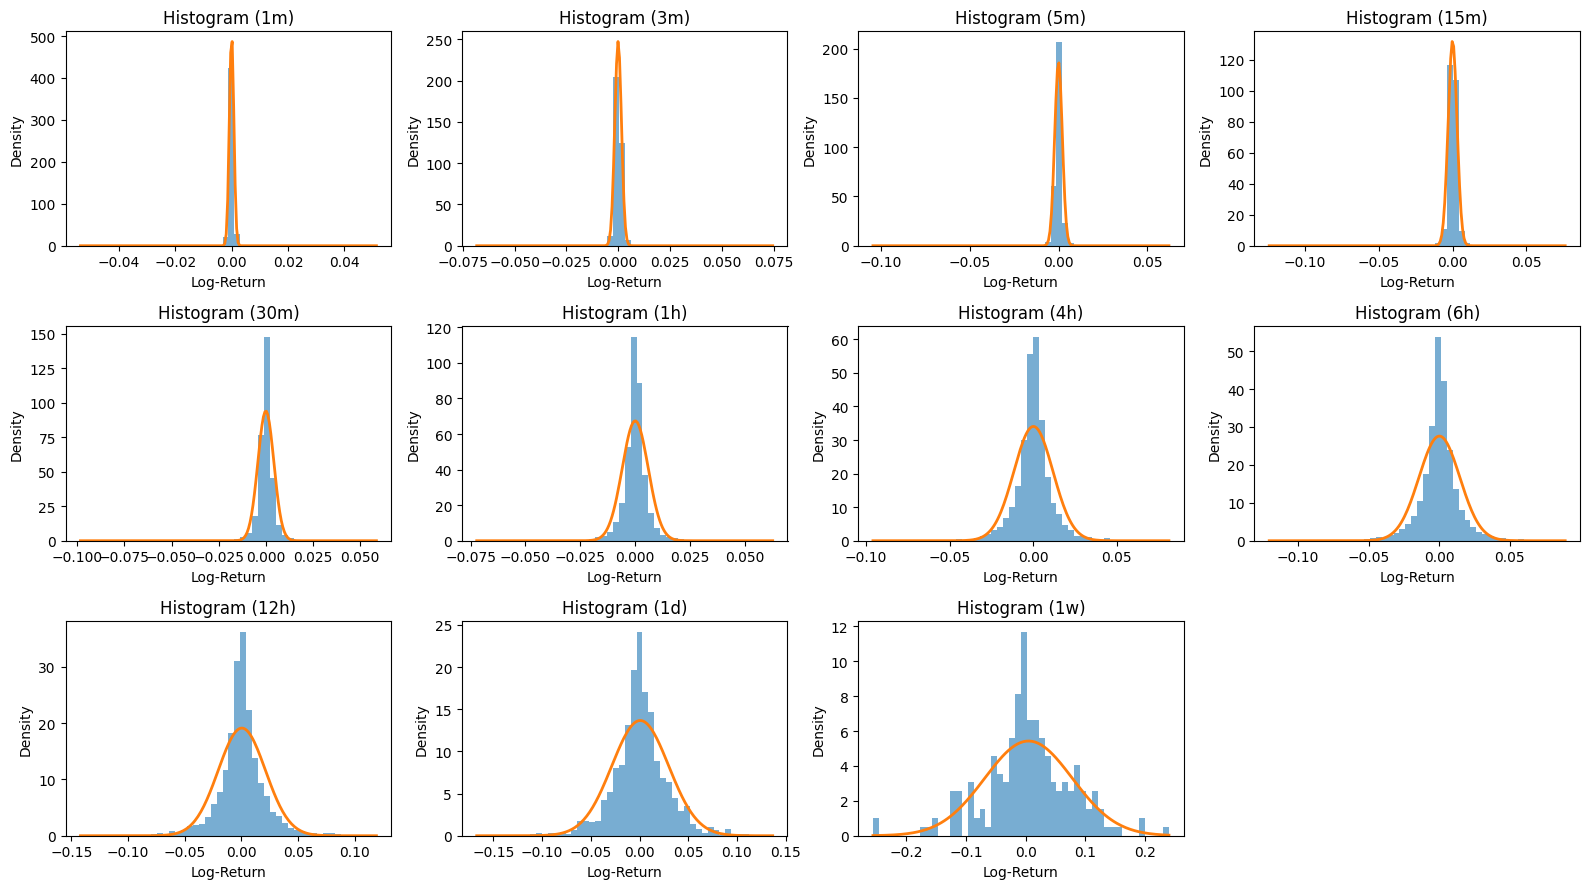

In [9]:
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
axes = axes.flatten()

for i, tf in enumerate(timeframes):
    ax = axes[i]
    series = rets[tf]

    # plot histogram + normal overlay
    ax.hist(series, bins=50, density=True, alpha=0.6)
    x = np.linspace(series.min(), series.max(), 200)
    pdf = (1 / (series.std() * np.sqrt(2 * np.pi))) * \
          np.exp(-((x - series.mean())**2) / (2 * series.std()**2))
    ax.plot(x, pdf, linewidth=2)

    ax.set_title(f"Histogram ({tf})")
    ax.set_xlabel("Log-Return")
    ax.set_ylabel("Density")

# turn off any unused axes
for j in range(n, rows * cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


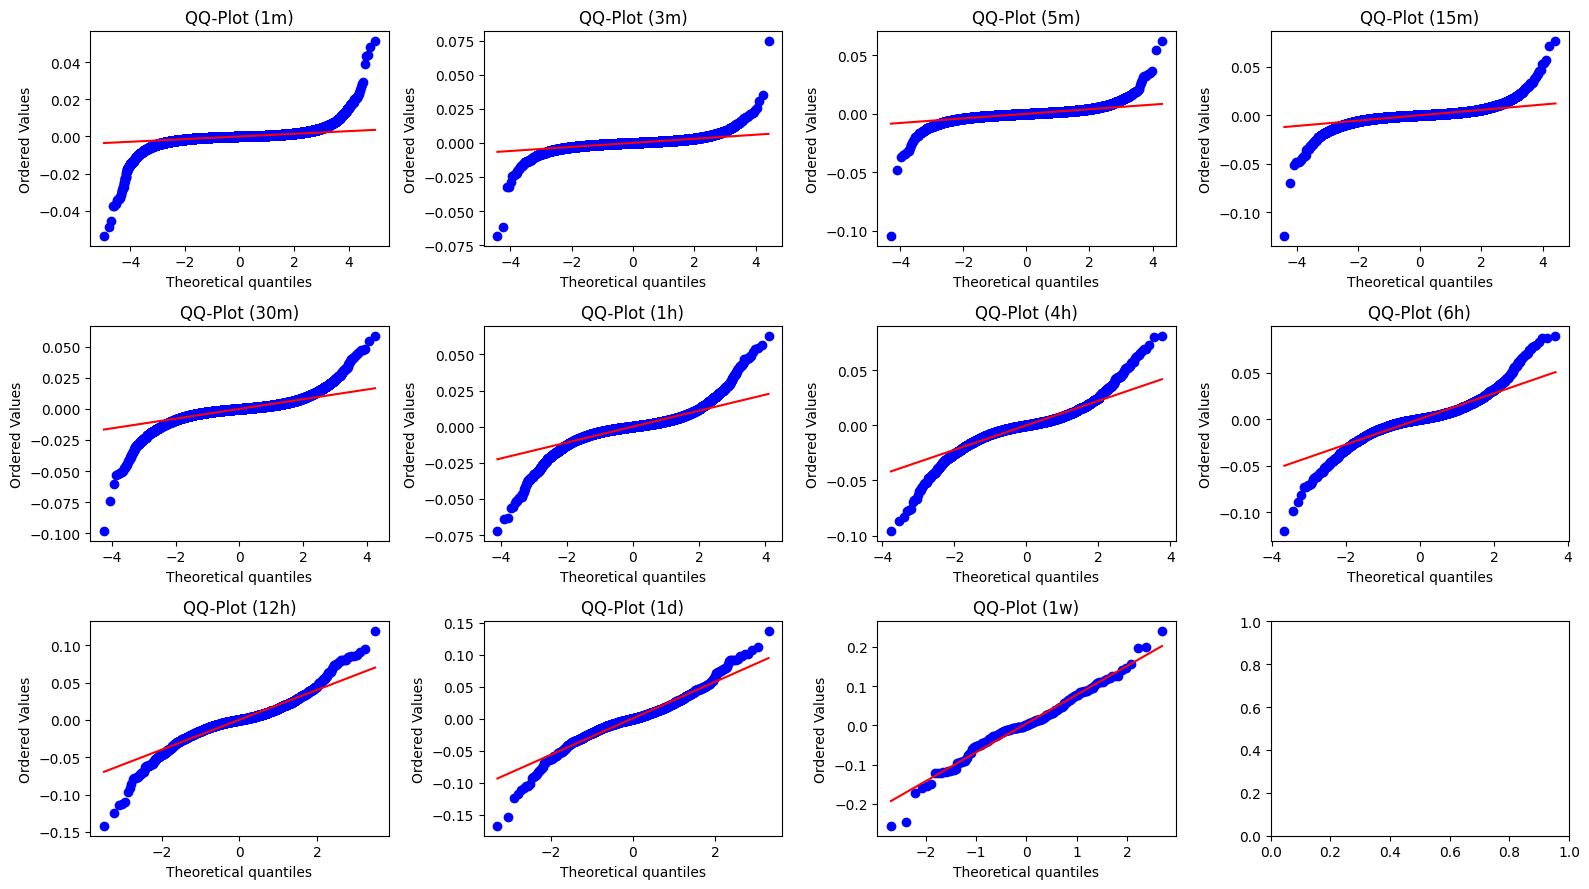

In [10]:
# 2) QQ-Plots vs. Gaussian
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
axes = axes.flatten()

for i, tf in enumerate(timeframes):
    ax = axes[i]
    probplot(rets[tf], dist="norm", plot=ax)
    ax.set_title(f"QQ-Plot ({tf})")
fig.tight_layout()
plt.show()



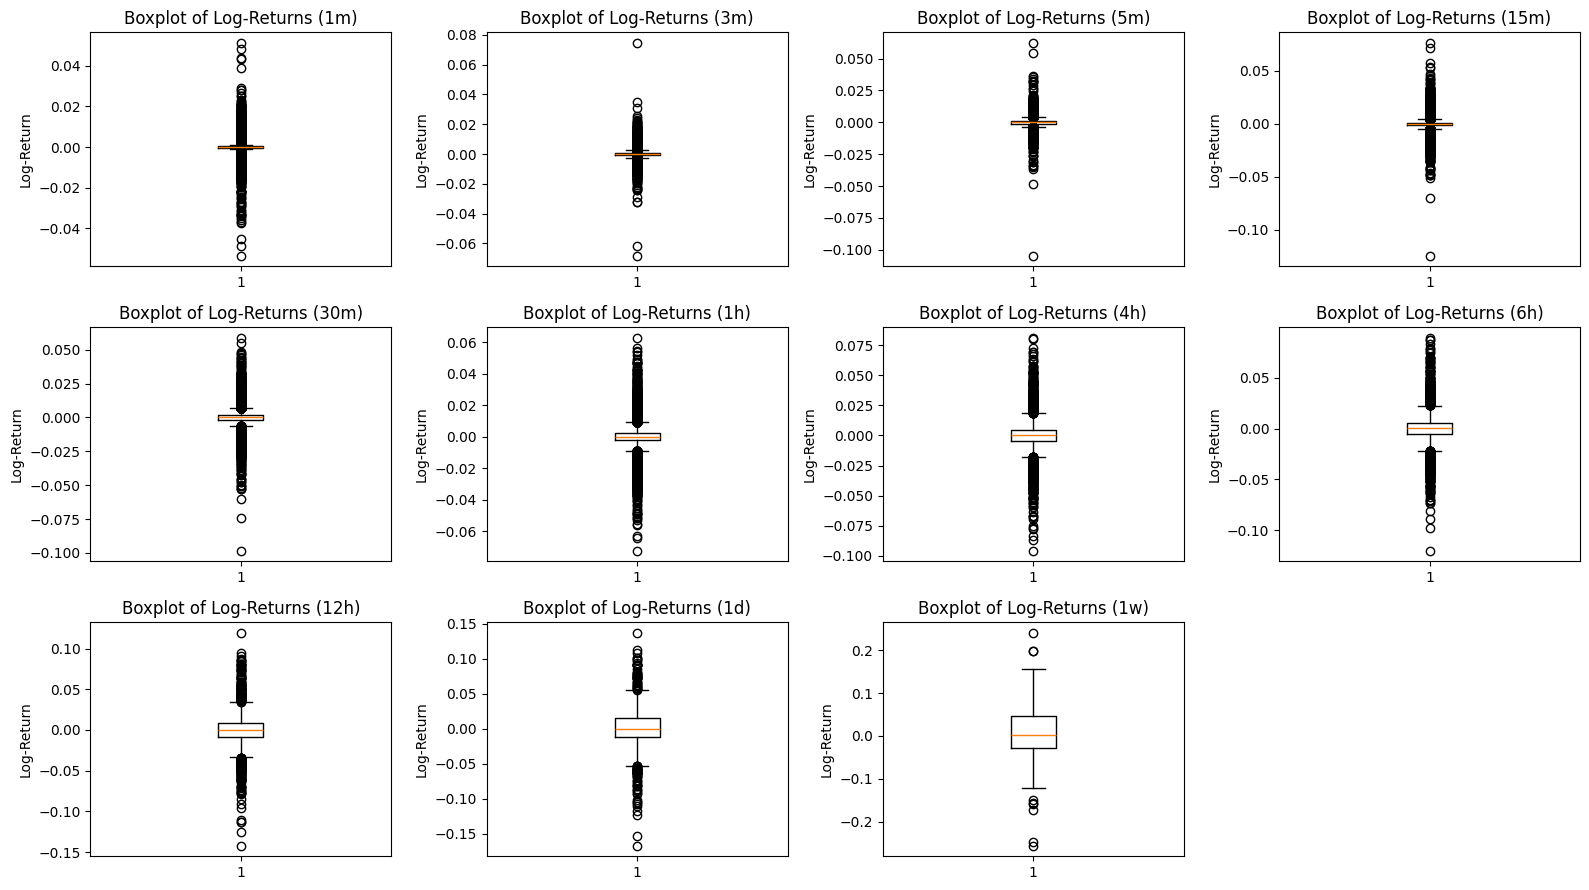

In [11]:
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
axes = axes.flatten()

for i, tf in enumerate(timeframes):
    ax = axes[i]
    ax.boxplot(rets[tf])
    ax.set_title(f"Boxplot of Log-Returns ({tf})")
    ax.set_ylabel("Log-Return")

# Remove any unused subplots
for j in range(n, rows * cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

## B. Volume

In [12]:
vols = {}
for tf in timeframes:
    df = ohlcv[tf]
    vols[tf] = df['volume'].dropna()

stats = []
for tf, series in vols.items():
    stats.append({
        'timeframe': tf,
        'mean': series.mean(),
        'std': series.std(),
        'skew': skew(series),
        'kurtosis': kurtosis(series)
    })
stats_df = pd.DataFrame(stats)
print("Descriptive Statistics:")
print(stats_df)

Descriptive Statistics:
   timeframe          mean           std       skew    kurtosis
0         1m      6.877351     13.876782  13.673232  515.689593
1         3m      2.654538      5.051986   6.167093   75.302764
2         5m      4.115128      7.343988   5.966664   76.494564
3        15m    103.428632    158.037660   7.175418  138.074587
4        30m    206.894445    296.452096   5.706723   81.121227
5         1h    412.640789    554.555765   4.651351   53.703196
6         4h   1650.421516   1930.430241   2.726215   14.993340
7         6h   2475.781109   2796.187645   2.383740   10.227281
8        12h   4950.669440   5244.719156   1.959227    6.298233
9         1d   9897.779388   9895.263577   1.728416    4.691651
10        1w  68986.021999  58958.327914   0.953830    0.098515


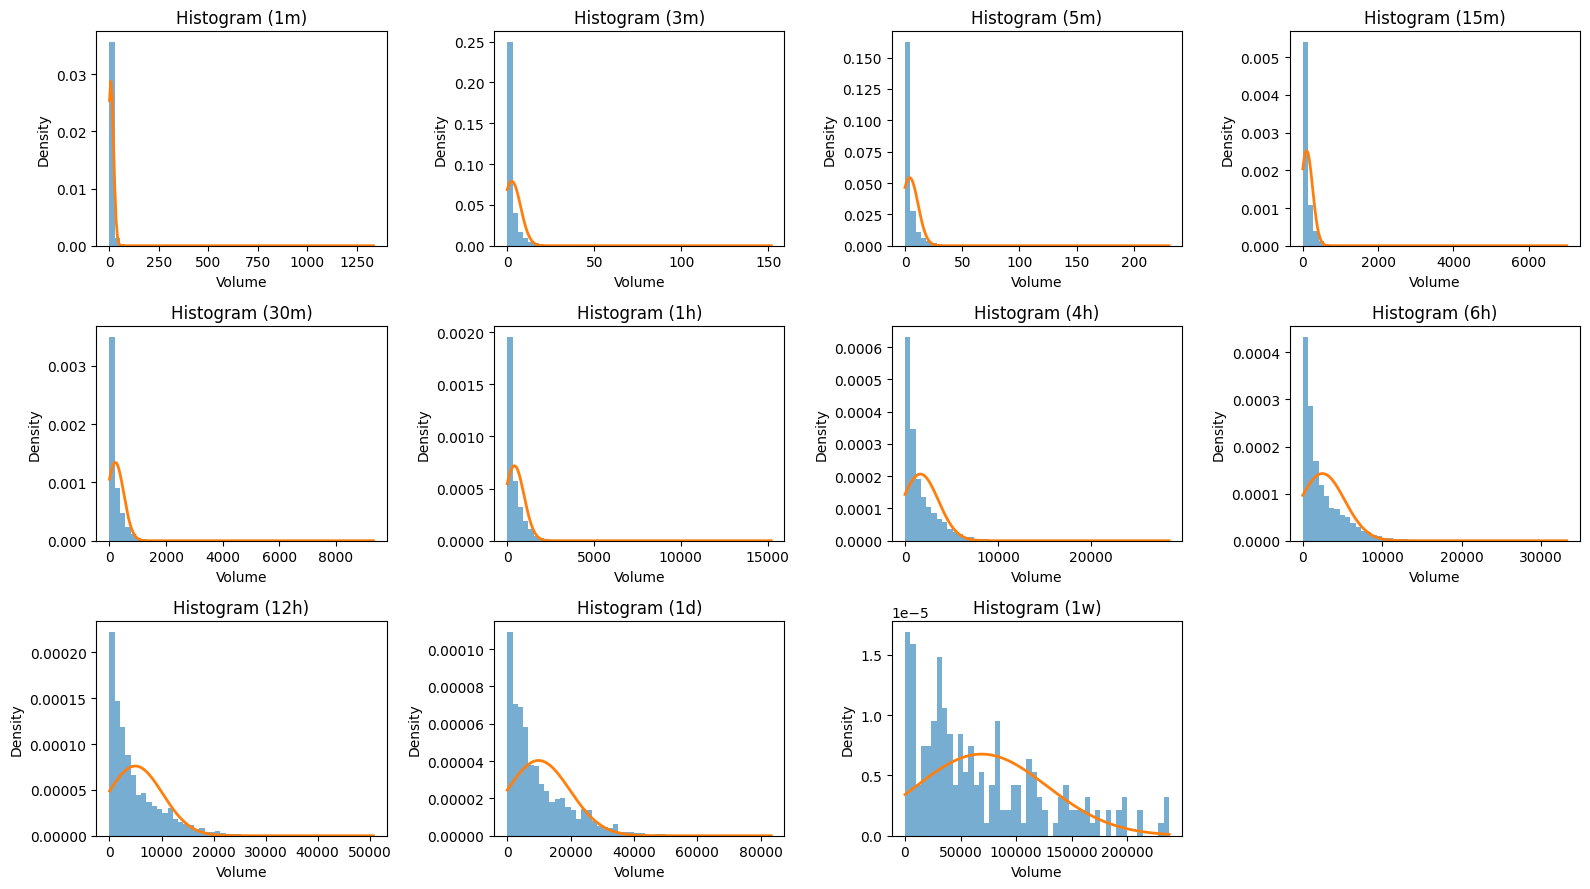

In [13]:
n = len(timeframes)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
axes = axes.flatten()

for i, tf in enumerate(timeframes):
    ax = axes[i]
    series = vols[tf]

    # plot histogram + normal overlay
    ax.hist(series, bins=50, density=True, alpha=0.6)
    x = np.linspace(series.min(), series.max(), 200)
    pdf = (1 / (series.std() * np.sqrt(2 * np.pi))) * \
          np.exp(-((x - series.mean())**2) / (2 * series.std()**2))
    ax.plot(x, pdf, linewidth=2)

    ax.set_title(f"Histogram ({tf})")
    ax.set_xlabel("Volume")
    ax.set_ylabel("Density")

# turn off any unused axes
for j in range(n, rows * cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


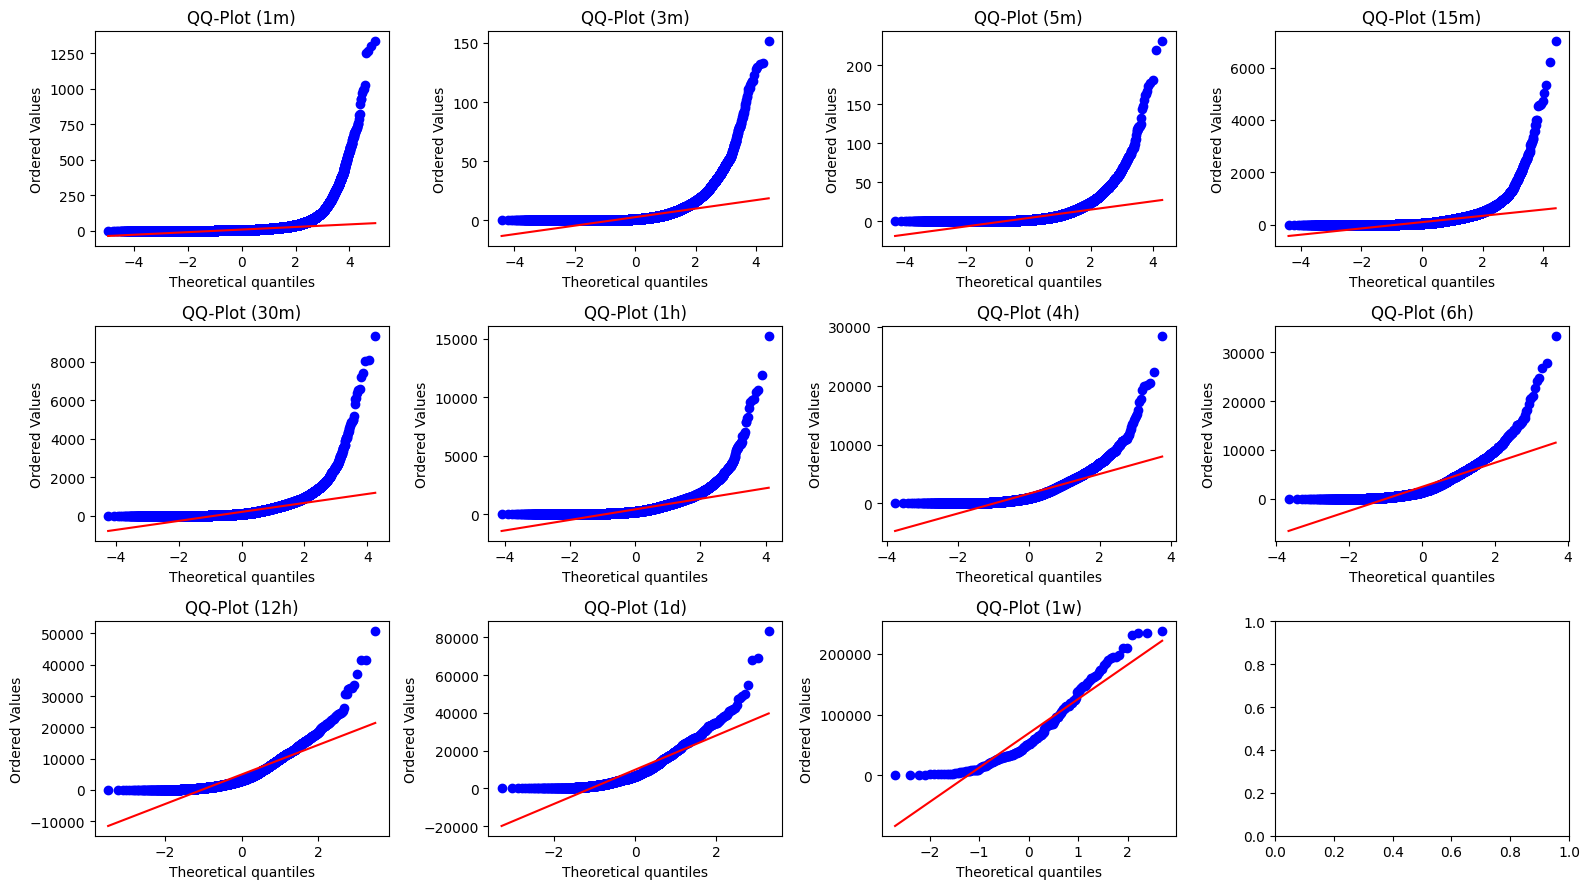

In [14]:
# 2) QQ-Plots vs. Gaussian
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
axes = axes.flatten()

for i, tf in enumerate(timeframes):
    ax = axes[i]
    probplot(vols[tf], dist="norm", plot=ax)
    ax.set_title(f"QQ-Plot ({tf})")
fig.tight_layout()
plt.show()



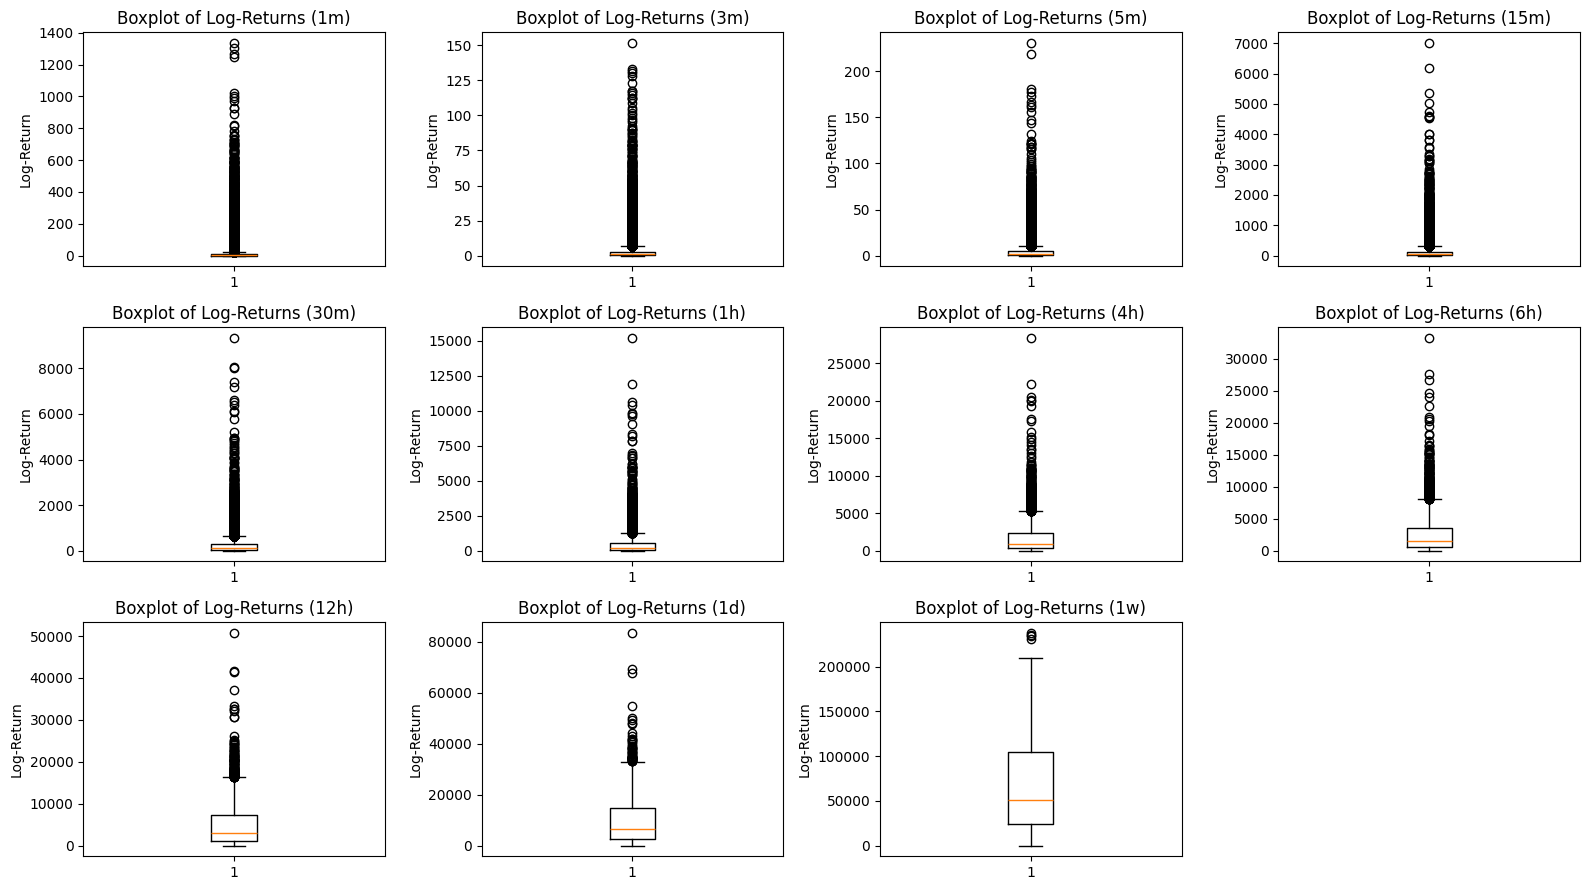

In [15]:
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
axes = axes.flatten()

for i, tf in enumerate(timeframes):
    ax = axes[i]
    ax.boxplot(vols[tf])
    ax.set_title(f"Boxplot of Log-Returns ({tf})")
    ax.set_ylabel("Log-Return")

# Remove any unused subplots
for j in range(n, rows * cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

# 3. Stationary & Autocorrelation 

ADF Test
- Check Stationary of price vs returns on each timeframe

ACF and Partial ACF Test
- plot ACF/PACF of returns and absolute returns (volatility) to identify memory
- helps decide how many lags to include in your sequence window

Result: 
- ADF Test reveasl that log return has stationary distribution
- log return is white noise: pure randomness, by definition it has zero autocorrelation at all non-zero lags. 
- No AR or MA structure to exploit.

## ADF Test

In [16]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

rets = {}
for tf in timeframes:
    df = ohlcv[tf]
    rets[tf] = np.log(df['close'] / df['close'].shift(1)).dropna()

adf_stat, p_value, used_lag, n_obs, crit_vals, icbest = adfuller(rets['1h'])
print("ADF Statistic:  ", adf_stat)
print("p-value:        ", p_value)
print("# lags used:    ", used_lag)
print("# observations: ", n_obs)
print("Critical values:")
for k, v in crit_vals.items():
    print(f"    {k}: {v:.3f}")

if p_value < 0.05:
    print("Series is stationary (reject H0 at 5% level).")
else:
    print("Series is non‐stationary (fail to reject H0).")

ADF Statistic:   -37.64740469846958
p-value:         0.0
# lags used:     24
# observations:  33243
Critical values:
    1%: -3.431
    5%: -2.862
    10%: -2.567
Series is stationary (reject H0 at 5% level).


## ACF and PACF Test

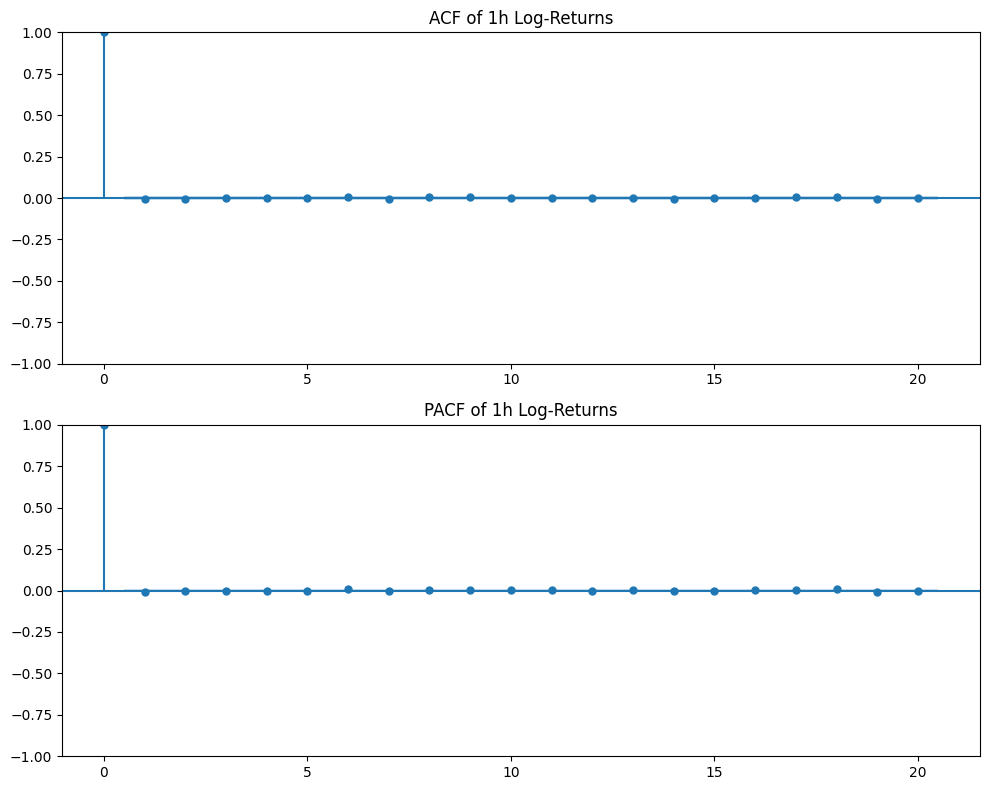

In [17]:
nlags = 20
tf = '1h'
acf_vals  = acf(rets[tf], nlags=nlags, fft=True)
pacf_vals = pacf(rets[tf], nlags=nlags, method='ywmle')

acf_df  = pd.DataFrame({'lag': np.arange(len(acf_vals)),  'acf': acf_vals})
pacf_df = pd.DataFrame({'lag': np.arange(len(pacf_vals)), 'pacf': pacf_vals})

# --- 4) ACF / PACF plots ---
fig, axes = plt.subplots(2,1, figsize=(10,8))
plot_acf(rets['1h'], lags=nlags, ax=axes[0], title="ACF of 1h Log-Returns")
plot_pacf(rets['1h'], lags=nlags, ax=axes[1], title="PACF of 1h Log-Returns")
plt.tight_layout()
plt.show()

## Correlation and Cross-Correlation for Lead-Lag Timeframes

In [26]:
rets = {}
for tf in timeframes:
    df = ohlcv[tf]
    rets[tf] = np.log(df['close'] / df['close'].shift(1)).dropna()

# 1) Correlation matrices
rets_df = pd.DataFrame(rets)  # align on timestamp, NaNs where missing
rets_df.head()


,1m,3m,5m,15m,30m,1h,4h,6h,12h,1d,1w
datetime,,,,,,,,,,,
2021-07-05 12:01:00,0.002572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-05 12:02:00,0.000139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-05 12:03:00,0.000350,0.000373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-05 12:04:00,0.000448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-05 12:05:00,-0.000426,NaN,-0.002111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


=== Pearson Correlation Matrix ===


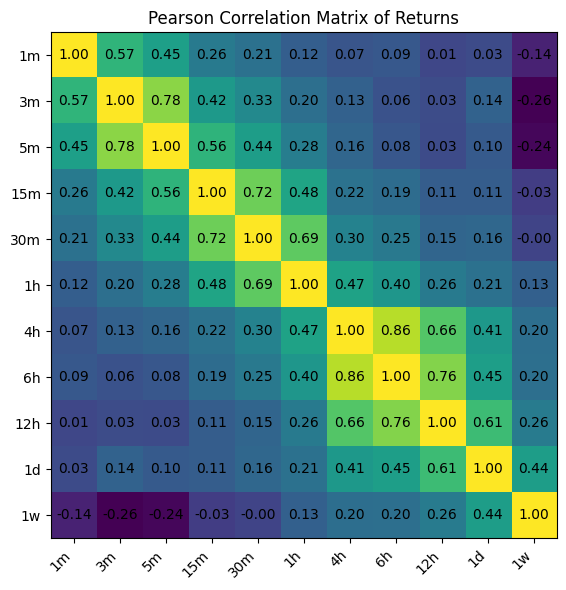

In [ ]:
pearson_corr = rets_df.corr(method='pearson')

fig, ax = plt.subplots(figsize=(8, 6))
# draw the matrix
im = ax.imshow(pearson_corr.values, aspect='equal')

# tick marks and labels
n = len(pearson_corr)
ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(pearson_corr.columns, rotation=45, ha='right')
ax.set_yticklabels(pearson_corr.index)

# annotate each cell with its correlation value
for (i, j), val in np.ndenumerate(pearson_corr.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center')

ax.set_title("Pearson Correlation Matrix of Returns")
plt.tight_layout()
plt.show()


=== Spearman Correlation Matrix ===


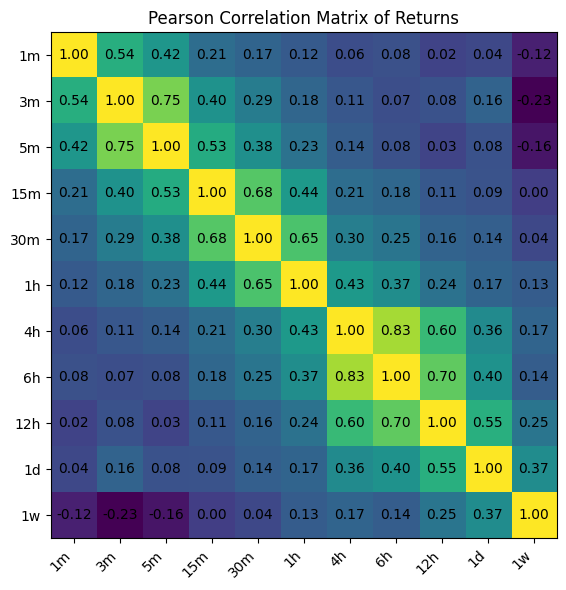

In [ ]:
spearman_corr = rets_df.corr(method='spearman')

fig, ax = plt.subplots(figsize=(8, 6))
# draw the matrix
im = ax.imshow(spearman_corr.values, aspect='equal')

# tick marks and labels
n = len(spearman_corr)
ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(spearman_corr.columns, rotation=45, ha='right')
ax.set_yticklabels(spearman_corr.index)

# annotate each cell with its correlation value
for (i, j), val in np.ndenumerate(spearman_corr.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center')

ax.set_title("Spearman Correlation Matrix of Returns")
plt.tight_layout()
plt.show()

In [60]:
df_test = {}
df_test['1d'] = rets['1d']
df_test['12'] = rets['12h']
df_test['12_shift_1'] = rets['12h'].shift(1)
df_test['12_shift_2'] = rets['12h'].shift(2)
df_test = pd.DataFrame(df_test)
df_test.head()

,1d,12,12_shift_1,12_shift_2
datetime,,,,
2021-07-06 00:00:00,0.015312,0.011438,NaN,NaN
2021-07-06 12:00:00,NaN,0.003873,0.011438,NaN
2021-07-07 00:00:00,-0.010549,0.017598,0.003873,0.011438
2021-07-07 12:00:00,NaN,-0.028147,0.017598,0.003873
2021-07-08 00:00:00,-0.029156,-0.035141,-0.028147,0.017598


In [ ]:
# Cross-correlation helper
def cross_correlation(s1: pd.Series, s2: pd.Series, max_lag: int):
    """
    Compute Corr(s1[t], s2[t + k]) for k in [-max_lag ... +max_lag].
    Returns a Series indexed by lag k.
    """
    lags = range(-max_lag, max_lag + 1)
    cors = []
    for k in lags:
        # shift s2 so that s2.shift(-k)[t] = original s2[t+k]
        shifted = s2.shift(-k)
        # pandas .corr will auto‐drop NaNs
        cors.append(s1.corr(shifted))
    return pd.Series(cors, index=lags)

# Automatically pick the strongest lead/lag across all pairs
results = []
for tf1 in rets.keys():
    for tf2 in rets.keys():
        if tf1 == tf2:
            continue
        cc = cross_correlation(rets[tf1], rets[tf2], max_lag=20)
        best_k = cc.abs().idxmax()
        results.append({
            'leader': tf1,
            'lagger': tf2,
            'best_lag': best_k,
            'corr':    cc.loc[best_k]
        })

df_leadlag = pd.DataFrame(results)
print("\nDetected strongest lead/lag relationships:")

# Print when lag != 0
df_leadlag[df_leadlag['best_lag'] != 0].sort_values('corr',ascending=False)


Detected strongest lead/lag relationships:


,leader,lagger,best_lag,corr
98,1d,12h,1,0.781843
54,1h,30m,1,0.707442
109,1w,1d,4,0.607588
10,3m,1m,1,0.588582
97,1d,6h,3,0.575223
...,...,...,...,...
38,15m,1d,-1,-0.164381
9,1m,1w,7,-0.181569
100,1w,1m,-12,-0.214126
102,1w,5m,-17,-0.376503


In [80]:
# assume rets['1d'] and rets['12h'] exist as pd.Series
r1d    = rets['1d']
r12h   = rets['12h']
# shift 12h series so that at time t we see the *next* 12 h return
next12h = r12h.shift(-1)
df_tnj = pd.DataFrame({'r1d': r1d, 'r12h_next': next12h}).dropna()

# Correlation
print("Pearson Correlation:", df_tnj['r1d'].corr(df_tnj['r12h_next']))
print("Spearman Correlation:", df_tnj['r1d'].corr(df_tnj['r12h_next'], method='spearman'))

Pearson Correlation: 0.7818434709960925
Spearman Correlation: 0.7675864652978075


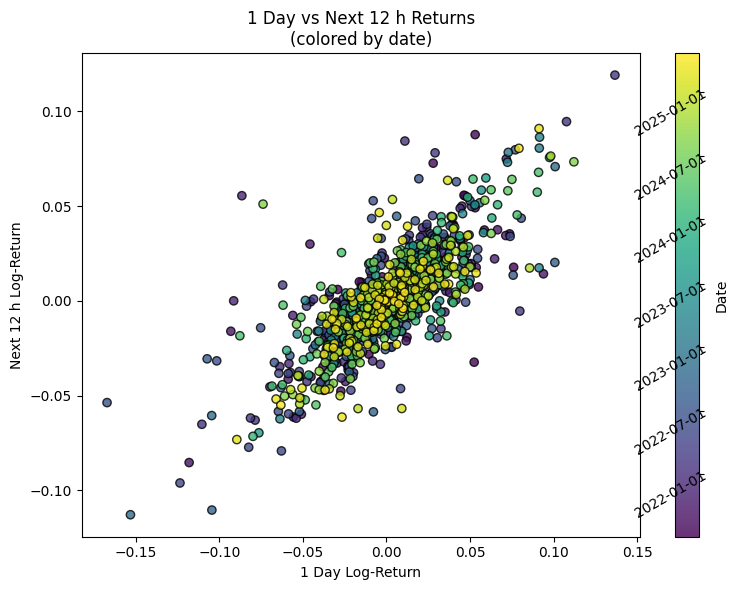

In [81]:
import matplotlib.dates as mdates

# x, y and the dates
x     = df_tnj['r1d']
y     = df_tnj['r12h_next']
dates = df_tnj.index

# convert datetime to Matplotlib’s float date format
date_nums = mdates.date2num(dates)

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(
    x, y,
    c=date_nums,
    cmap='viridis',
    marker='o',
    edgecolor='k',
    alpha=0.8
)

ax.set_xlabel('1 Day Log-Return')
ax.set_ylabel('Next 12 h Log-Return')
ax.set_title('1 Day vs Next 12 h Returns\n(colored by date)')

# add a colorbar and format its ticks as dates
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Date')
cbar.ax.yaxis.set_major_locator(mdates.AutoDateLocator())
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# rotate the date labels on the colorbar for readability
plt.setp(cbar.ax.get_yticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.show()

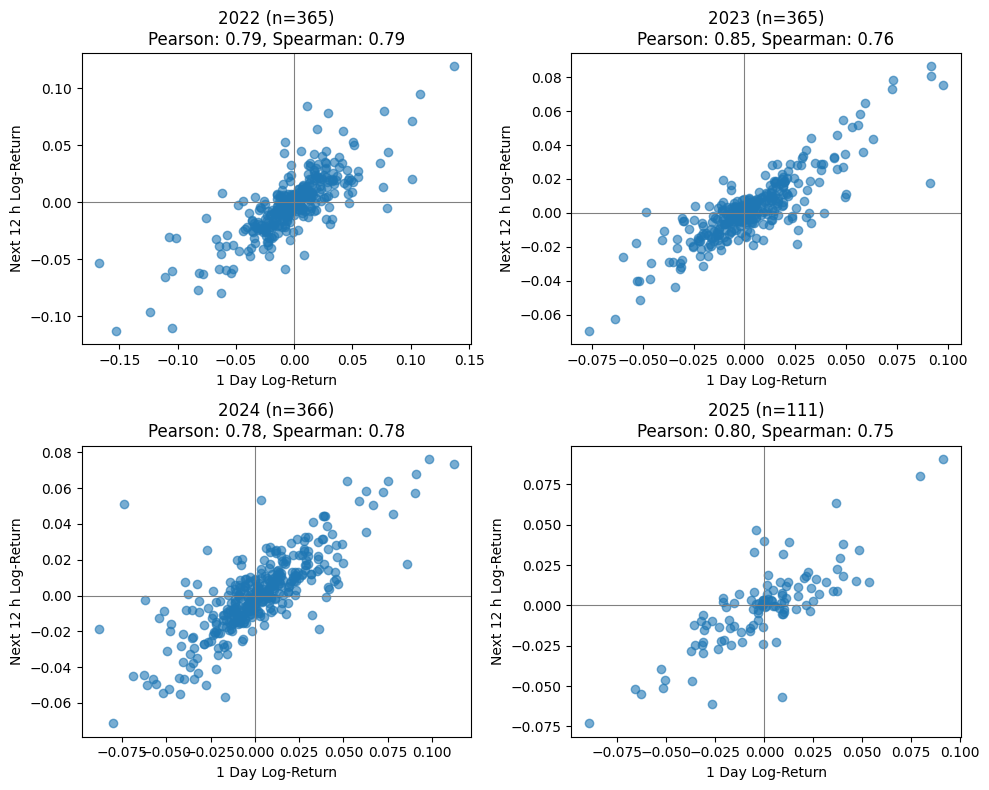

In [86]:
# List of years to plot
years = [2022, 2023, 2024, 2025]

# Prepare 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, year in zip(axes, years):
    # Filter for that year
    sub = df_tnj[df_tnj.index.year == year]
    n = len(sub)
    if n == 0:
        ax.set_title(f"{year}: no data")
        ax.set_axis_off()
        continue

    # Compute Pearson & Spearman
    pearson = sub['r1d'].corr(sub['r12h_next'])
    spearman = sub['r1d'].corr(sub['r12h_next'], method='spearman')

    # Scatter plot
    ax.scatter(sub['r1d'], sub['r12h_next'], alpha=0.6)
    ax.axhline(0, color='gray', linewidth=0.8)
    ax.axvline(0, color='gray', linewidth=0.8)

    # Title with both correlations
    ax.set_title(
        f"{year} (n={n})\n"
        f"Pearson: {pearson:.2f}, Spearman: {spearman:.2f}"
    )
    ax.set_xlabel("1 Day Log-Return")
    ax.set_ylabel("Next 12 h Log-Return")

# Hide any unused subplots (if years < 4)
for j in range(len(years), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

In [63]:
pos = df_tnj[df_tnj['r1d'] > 0]
neg = df_tnj[df_tnj['r1d'] <= 0]

for name, subset in [('Up-day', pos), ('Down-day', neg)]:
    mean12 = subset['r12h_next'].mean()
    winrate = (subset['r12h_next'] > 0).mean()
    vol12 = subset['r12h_next'].std()
    print(f"{name}: E[next12h]={mean12:.4%},  Win-rate={winrate:.1%},  Std={vol12:.2%}")


Up-day: E[next12h]=1.3269%,  Win-rate=79.8%,  Std=1.96%
Down-day: E[next12h]=-1.2236%,  Win-rate=22.8%,  Std=1.92%
